In [1]:
from glob import glob

import mne
import numpy as np
import pandas as pd
from antropy import detrended_fluctuation, higuchi_fd, lziv_complexity, sample_entropy
from matplotlib import pyplot as plt
from mne.io import RawArray
from sbci.utils import sliding_window

plt.rcParams["figure.figsize"] = (16, 6)

In [2]:
print("Found paths:")
print("\n".join(sorted(glob("data/*.csv"))))

Found paths:
data/mindMonitor_2025-06-23--03-58-24_627438371315510904.csv
data/mindMonitor_2025-06-24--02-21-45_2869420056717168472.csv
data/mindMonitor_2025-06-24--04-46-01_2705913091212515367.csv
data/mindMonitor_2025-06-26--07-42-07_1768117374314291249.csv
data/mindMonitor_2025-06-27--00-55-27_4100920391605158892.csv


In [3]:
PATH = "data/mindMonitor_2025-06-27--00-55-27_4100920391605158892.csv"

MOVEMENT_WINDOW = 256
MOVEMENT_THRESH = 0.02
MOVEMENT_SMOOTHING = 256 * 20
CHANNELS = ["RAW_AF7", "RAW_AF8", "RAW_TP9", "RAW_TP10"]
WINDOW_SECONDS = 15
STEP_SECONDS = 10

In [4]:
if isinstance(PATH, str):
    PATH = [PATH]

dfs = [pd.read_csv(p).iloc[1:] for p in PATH]
df = pd.concat(dfs, ignore_index=True)
df.index = df.index / 256 / 60

df["Movement"] = np.linalg.norm(df[["Accelerometer_X", "Accelerometer_Y", "Accelerometer_Z"]], axis=1)

# remove movement artifacts
# is_moving = df["Movement"].rolling(MOVEMENT_WINDOW, center=True).std() > MOVEMENT_THRESH  # detect movement
# is_moving = is_moving.rolling(MOVEMENT_SMOOTHING * 2, center=True).max().fillna(1).astype(bool)  # smoothing
# df = df[~is_moving]
# df[is_moving] = np.nan
df = df.ffill()

df

/tmp/ipykernel_49036/2501387962.py:4: DtypeWarning: Columns (34,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(p).iloc[1:] for p in PATH]


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,PPG_Red,Heart_Rate,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements,Movement
0.000000,2025-06-27 00:55:26.996,0.131583,-0.374994,0.428549,0.518251,0.095524,-0.179452,0.302172,0.177169,0.377536,...,3.461978e+06,67.170180,1.0,1.0,1.0,1.0,1.0,100.0,NaN,0.999871
0.000065,2025-06-27 00:55:27.000,0.131583,-0.374994,0.428549,0.518251,0.095524,-0.179452,0.302172,0.177169,0.377536,...,3.461978e+06,67.170180,1.0,1.0,1.0,1.0,1.0,100.0,NaN,0.999871
0.000130,2025-06-27 00:55:27.004,0.131583,-0.374994,0.428549,0.518251,0.095524,-0.179452,0.302172,0.177169,0.377536,...,3.461978e+06,67.170180,1.0,1.0,1.0,1.0,1.0,100.0,NaN,0.999871
0.000195,2025-06-27 00:55:27.008,0.131583,-0.374994,0.428549,0.518251,0.095524,-0.179452,0.302172,0.177169,0.377536,...,3.461978e+06,67.170180,1.0,1.0,1.0,1.0,1.0,100.0,NaN,0.999871
0.000260,2025-06-27 00:55:27.012,0.131583,-0.374994,0.428549,0.518251,0.095524,-0.179452,0.302172,0.177169,0.377536,...,3.461978e+06,67.170180,1.0,1.0,1.0,1.0,1.0,100.0,NaN,0.999871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411.785937,2025-06-27 07:50:34.613,1.488827,0.507313,-0.004149,1.416104,1.375299,0.065522,-0.010918,1.277260,1.174720,...,3.661026e+06,85.557335,1.0,1.0,1.0,1.0,1.0,17.0,/muse/elements/blink,0.999962
411.786003,2025-06-27 07:50:34.617,1.488827,0.507313,-0.004149,1.416104,1.375299,0.065522,-0.010918,1.277260,1.174720,...,3.661026e+06,85.557335,1.0,1.0,1.0,1.0,1.0,17.0,/muse/elements/blink,0.999962
411.786068,2025-06-27 07:50:34.621,1.488827,0.507313,-0.004149,1.416104,1.375299,0.065522,-0.010918,1.277260,1.174720,...,3.661026e+06,85.557335,1.0,1.0,1.0,1.0,1.0,17.0,/muse/elements/blink,0.999962
411.786133,2025-06-27 07:50:34.625,1.488827,0.507313,-0.004149,1.416104,1.375299,0.065522,-0.010918,1.277260,1.174720,...,3.661026e+06,85.557335,1.0,1.0,1.0,1.0,1.0,17.0,/muse/elements/blink,0.999962


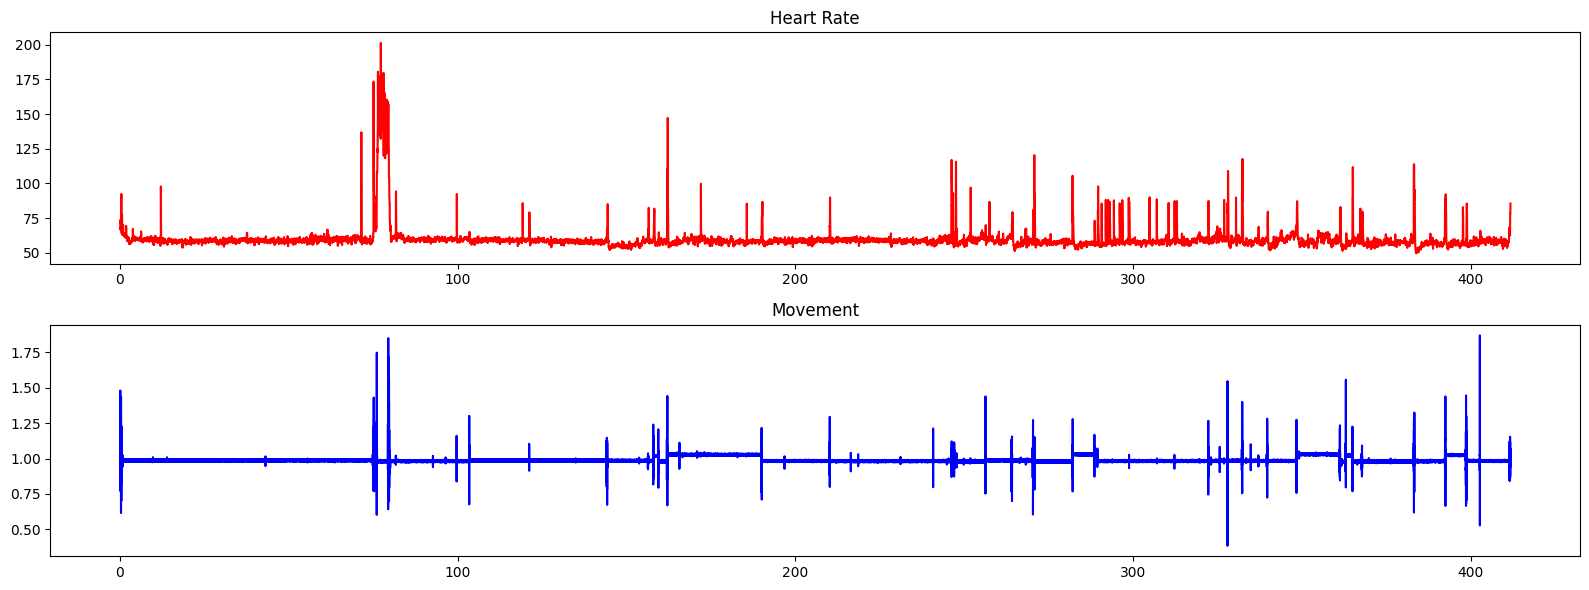

In [5]:
df["Heart_Rate"].plot(ax=plt.subplot(211), title="Heart Rate", color="red")
df["Movement"].plot(ax=plt.subplot(212), title="Movement", color="blue")
plt.tight_layout()

Creating RawArray with float64 data, n_channels=5, n_times=6325037
    Range : 0 ... 6325036 =      0.000 ... 24707.172 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 91.00 Hz)
- Filter length: 423 samples (1.652 s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.4s finished


Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_49036/4243869543.py:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/home/philipp/mambaforge/envs/nf/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


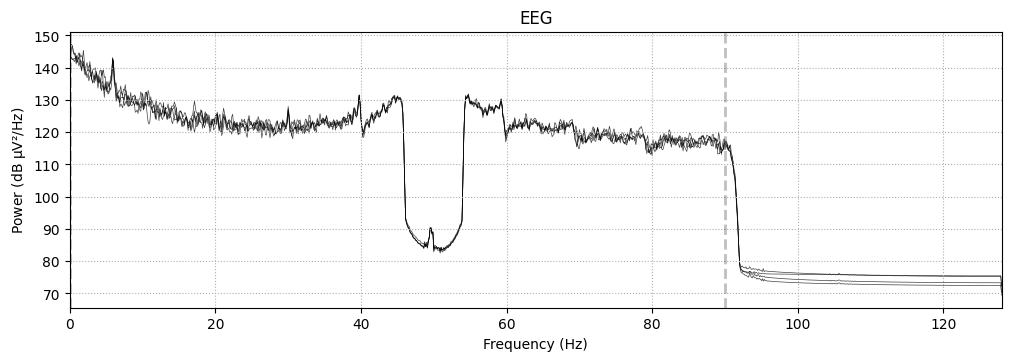

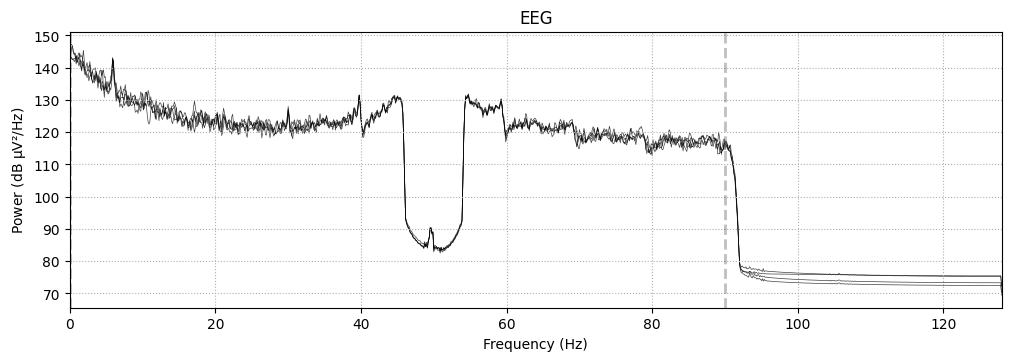

In [6]:
raw = RawArray(
    df[CHANNELS + ["Movement"]].values.T,
    mne.create_info(ch_names=CHANNELS + ["Movement"], sfreq=256, ch_types=["eeg"] * len(CHANNELS) + ["misc"]),
)

raw.notch_filter(np.arange(50, 128, 50), notch_widths=8)
raw.filter(0, 90, n_jobs=-1, l_trans_bandwidth=0.5, h_trans_bandwidth=2.0, fir_design="firwin")
raw.compute_psd().plot()

In [ ]:
def run_timeresolved(raw, func, smoothing=10, name=""):
    def _movement(x, sfreq):
        return np.std(x)

    _, movement = sliding_window(
        raw.copy().pick("Movement"), _movement, window_seconds=WINDOW_SECONDS, step_seconds=STEP_SECONDS, channelwise=True
    )

    ts, cs = sliding_window(
        raw.copy().pick(CHANNELS), func, window_seconds=WINDOW_SECONDS, step_seconds=STEP_SECONDS, channelwise=True
    )
    ts = ts / 60
    cs = np.array(cs)

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, height_ratios=[15, 1])
    fig.suptitle(f"{name} - {func.__name__} (Window: {WINDOW_SECONDS}s, Step: {STEP_SECONDS}s)")
    pd.DataFrame(data=cs, index=ts, columns=CHANNELS).rolling(smoothing, center=True).median().plot(ax=ax1)

    start = None
    for i, m in enumerate(movement):
        if m > 0.03 and start is None:
            start = i
        elif m < 0.03 and start is not None:
            ax1.axvspan(ts[start], ts[i], color="red", alpha=0.2)
            start = None

    ax1.set_ylabel(name)
    movement_img = np.expand_dims(movement, axis=0)
    ax2.imshow(movement_img, aspect="auto", extent=[ts[0], ts[-1], 0, 1], cmap="Reds")
    ax2.set_ylabel("Movement", rotation=0, ha="right", va="center")
    ax2.set_xlabel("Time (min)")
    ax2.set_yticks([])
    plt.subplots_adjust(hspace=0)
    plt.show()


def lzc(x, sfreq):
    x = x > x.mean()
    return lziv_complexity(x, normalize=True)


def hfd(x, sfreq):
    return higuchi_fd(x)


def dfa(x, sfreq):
    return detrended_fluctuation(x)


def se(x, sfreq):
    return sample_entropy(x)

100%|██████████| 2470/2470 [00:07<00:00, 317.19it/s] 


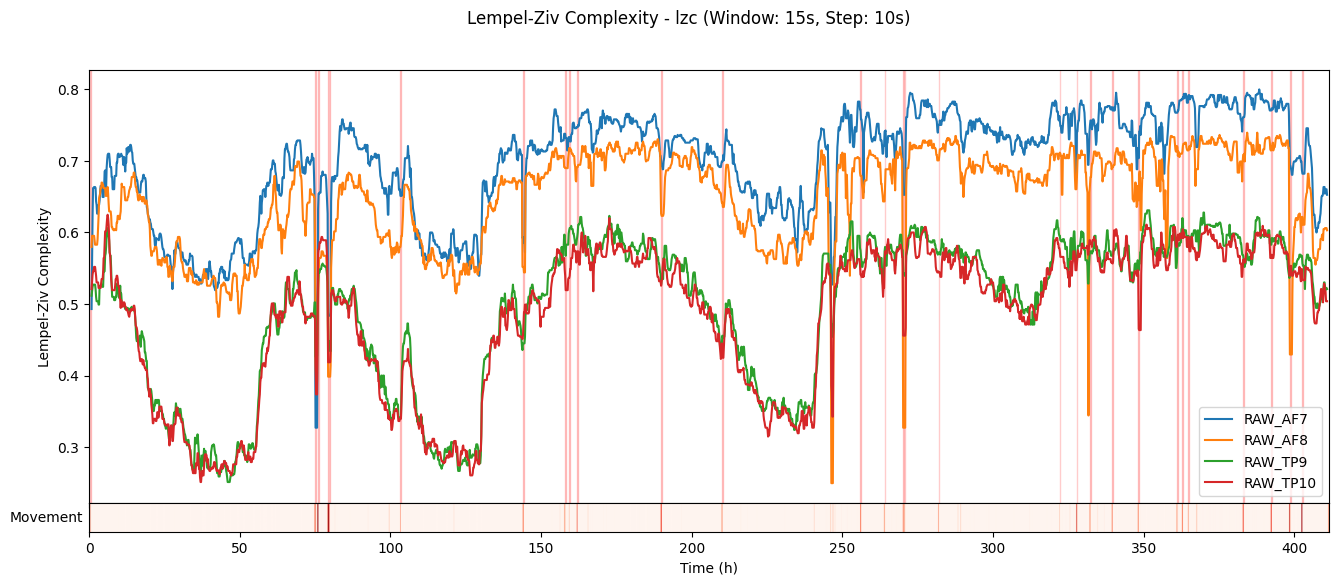

In [8]:
run_timeresolved(raw, lzc, name="Lempel-Ziv Complexity")

100%|██████████| 2470/2470 [00:00<00:00, 7397.13it/s]


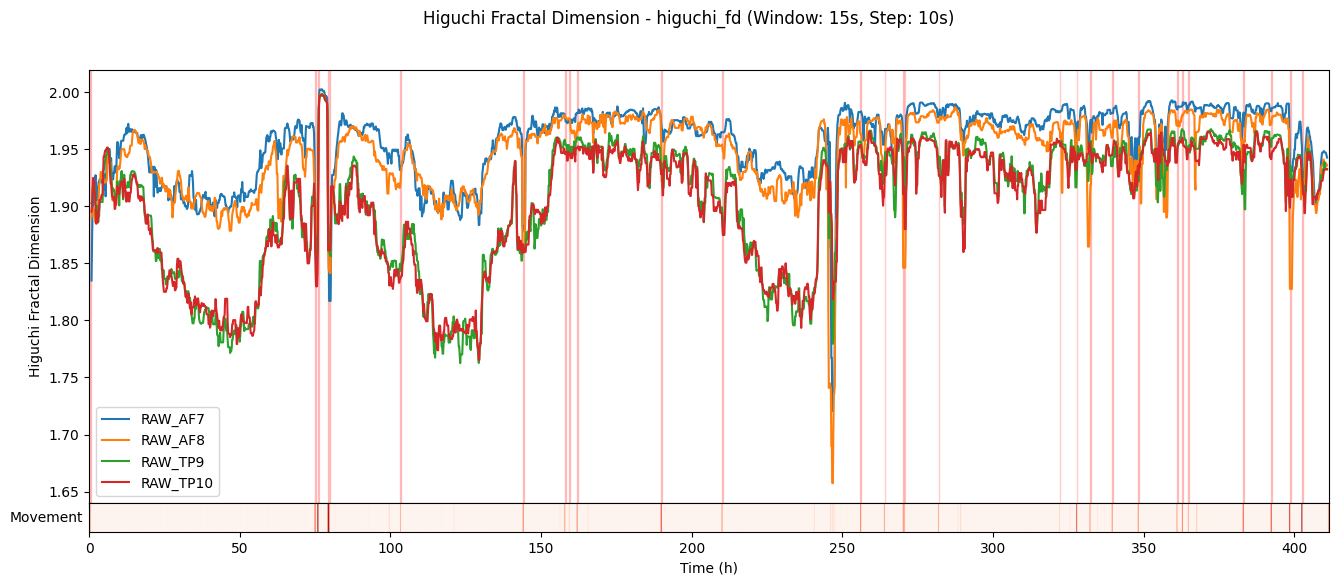

In [9]:
run_timeresolved(raw, higuchi_fd, name="Higuchi Fractal Dimension")

100%|██████████| 2470/2470 [00:00<00:00, 5498.67it/s]


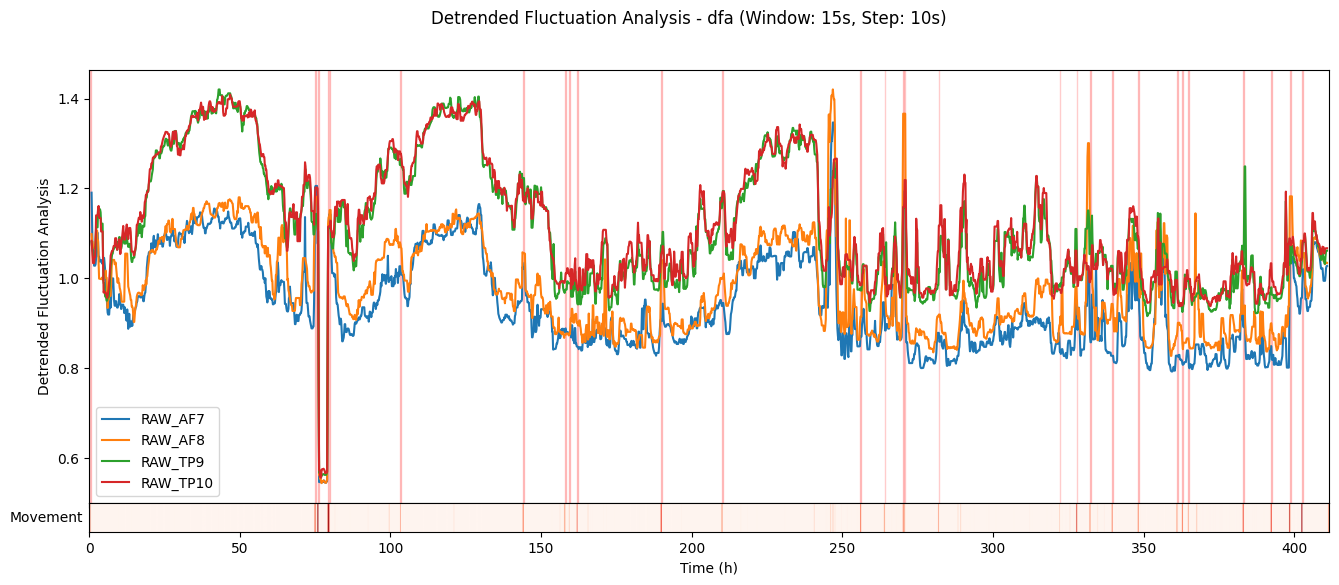

In [10]:
run_timeresolved(raw, dfa, name="Detrended Fluctuation Analysis")

100%|██████████| 2470/2470 [00:10<00:00, 229.10it/s]


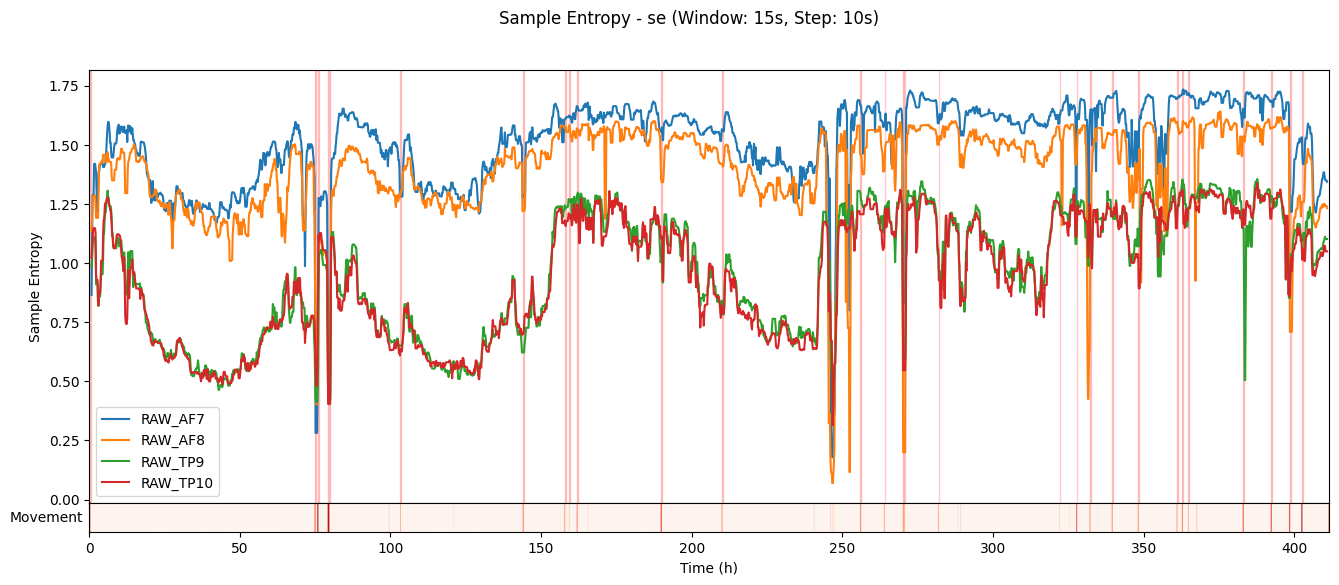

In [11]:
run_timeresolved(raw, se, name="Sample Entropy")